# Vision Transformer

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

#### Checking for cuda availability

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Get pretrained weights for ViT-Base

In [3]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [4]:
pretrained_vit_weights

ViT_B_16_Weights.IMAGENET1K_V1

#### Setup a ViT model instance with pretrained weights

In [5]:
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

In [6]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

#### Freeze the base parameters

In [7]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

#### classifier head

In [8]:
class_names = ['comb', 'doublemint', 'mouse', 'no_item', 'suns_cream', 'tooth_brush']

In [9]:
def set_seeds(seed: int = 42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [10]:
set_seeds()

In [11]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [12]:
pretrained_vit.heads

Linear(in_features=768, out_features=6, bias=True)

## Print a summary using torchinfo (uncomment for actual output)

In [13]:
from torchinfo import summary

In [14]:
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

C:\Users\Public\anaconda3\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Short version of the model

In [15]:
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"],
        # col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]
├─Encoder (encoder)                                          [32, 197, 768]
│    └─Dropout (dropout)                                     [32, 197, 768]
│    └─Sequential (layers)                                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_3)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_4)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_5)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_6)                   [32, 197, 768]
│    │   

In [16]:
train_dir = 'C:/Users/Ishika Saha/Desktop/Aryan/GithubRepo/SDP/Vision Transformer/DATASET/train'
test_dir = 'C:/Users/Ishika Saha/Desktop/Aryan/GithubRepo/SDP/Vision Transformer/DATASET/test'

## Get automatic transforms from pretrained ViT weights

In [17]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [18]:
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [19]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [20]:
NUM_WORKERS = 0

In [21]:
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

## Setup dataloaders

In [22]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=32) # Could increase if we had more samples

In [23]:
def calculate_accuracy(y_pred, y_true):
    correct = (y_pred.argmax(dim=1) == y_true).sum().item()
    acc = correct / len(y_true)
    return acc

#### Set seeds

In [24]:
set_seeds()

In [25]:
# this is used when using sheduler for lr
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        logprobs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

In [26]:
epochs=10

In [27]:
# optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
# loss_fn = torch.nn.CrossEntropyLoss()


# this is used when using sheduler for lr
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = AdamW(pretrained_vit.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [28]:
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [29]:
# Data storage for plotting later
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []
y_true = []
y_pred_list = []

In [30]:
def model_training(epochs):    
    for epoch in range(epochs):
        # === Training ===
        pretrained_vit.train()
        train_loss, train_acc = 0, 0
    
        train_loop = tqdm(train_dataloader_pretrained, desc=f"Epoch {epoch+1} [Train]", leave=False)
        for X, y in train_loop:
            X, y = X.to(device), y.to(device)
    
            y_pred = pretrained_vit(X)
            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            train_acc += acc
    
        train_loss /= len(train_dataloader_pretrained)
        train_acc /= len(train_dataloader_pretrained)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    
        # === Evaluation ===
        pretrained_vit.eval()
        test_loss, test_acc = 0, 0
    
        with torch.inference_mode():
            for X, y in test_dataloader_pretrained:
                X, y = X.to(device), y.to(device)
    
                y_pred = pretrained_vit(X)
                loss = loss_fn(y_pred, y)
                acc = calculate_accuracy(y_pred, y)
    
                test_loss += loss.item()
                test_acc += acc
    
                _, predicted = torch.max(y_pred, 1)
                y_true.extend(y.cpu().numpy())
                y_pred_list.extend(predicted.cpu().numpy())
    
        test_loss /= len(test_dataloader_pretrained)
        test_acc /= len(test_dataloader_pretrained)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    
        # === Precision, Recall, F1 ===
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_list, average='macro'  # Use 'weighted' or 'micro' if preferred
        )
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
        # ✅ Print for each epoch
        print(
            f"Epoch✅:{epoch+1} | "
            f"🔧train_loss:{train_loss:.4f} | 🏋️train_acc:{train_acc:.4f} | "
            f"🧪test_loss:{test_loss:.4f} | 🎯test_acc:{test_acc:.4f} | "
            f"📏precision:{precision:.3f} | 🔁recall:{recall:.3f} | 🧠f1:{f1:.3f}"
        )

        # ✅ Update the learning rate
        scheduler.step() # this is used when using sheduler for lr


In [31]:
model_training(epochs)

Epoch 1 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:1 | 🔧train_loss:1.3272 | 🏋️train_acc:0.6895 | 🧪test_loss:1.0073 | 🎯test_acc:0.8873 | 📏precision:0.896 | 🔁recall:0.886 | 🧠f1:0.884


Epoch 2 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:2 | 🔧train_loss:0.6918 | 🏋️train_acc:0.9824 | 🧪test_loss:0.7197 | 🎯test_acc:0.9564 | 📏precision:0.927 | 🔁recall:0.921 | 🧠f1:0.920


Epoch 3 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:3 | 🔧train_loss:0.5333 | 🏋️train_acc:0.9953 | 🧪test_loss:0.6296 | 🎯test_acc:0.9696 | 📏precision:0.941 | 🔁recall:0.937 | 🧠f1:0.936


Epoch 4 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:4 | 🔧train_loss:0.4866 | 🏋️train_acc:0.9973 | 🧪test_loss:0.5926 | 🎯test_acc:0.9745 | 📏precision:0.949 | 🔁recall:0.946 | 🧠f1:0.946


Epoch 5 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:5 | 🔧train_loss:0.4689 | 🏋️train_acc:0.9973 | 🧪test_loss:0.5738 | 🎯test_acc:0.9770 | 📏precision:0.955 | 🔁recall:0.952 | 🧠f1:0.952


Epoch 6 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:6 | 🔧train_loss:0.4607 | 🏋️train_acc:0.9977 | 🧪test_loss:0.5639 | 🎯test_acc:0.9770 | 📏precision:0.959 | 🔁recall:0.956 | 🧠f1:0.956


Epoch 7 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:7 | 🔧train_loss:0.4565 | 🏋️train_acc:0.9977 | 🧪test_loss:0.5581 | 🎯test_acc:0.9778 | 📏precision:0.962 | 🔁recall:0.959 | 🧠f1:0.959


Epoch 8 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:8 | 🔧train_loss:0.4542 | 🏋️train_acc:0.9980 | 🧪test_loss:0.5552 | 🎯test_acc:0.9778 | 📏precision:0.964 | 🔁recall:0.962 | 🧠f1:0.961


Epoch 9 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:9 | 🔧train_loss:0.4531 | 🏋️train_acc:0.9980 | 🧪test_loss:0.5538 | 🎯test_acc:0.9778 | 📏precision:0.966 | 🔁recall:0.963 | 🧠f1:0.963


Epoch 10 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch✅:10 | 🔧train_loss:0.4527 | 🏋️train_acc:0.9980 | 🧪test_loss:0.5535 | 🎯test_acc:0.9778 | 📏precision:0.967 | 🔁recall:0.965 | 🧠f1:0.965


## Train and Test Loss vs Epochs:

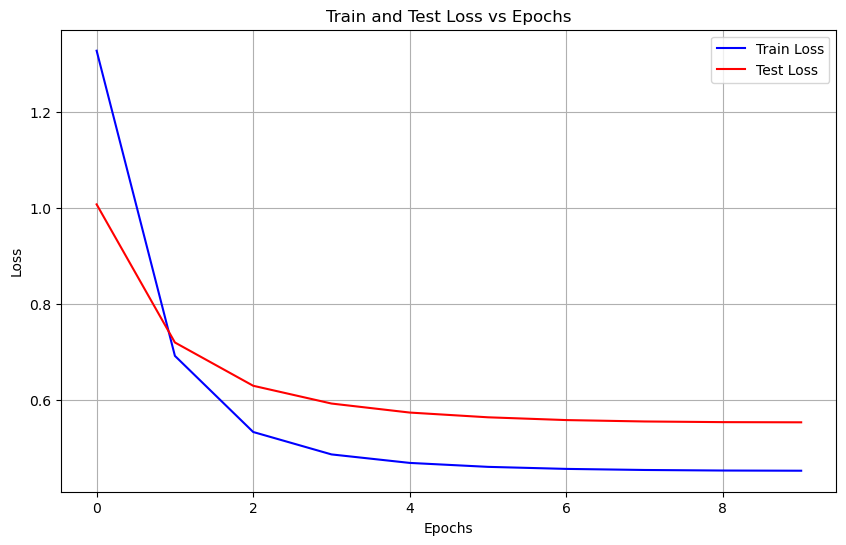

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss", color='blue')
plt.plot(range(epochs), test_losses, label="Test Loss", color='red')
plt.title("Train and Test Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Save the graph
plt.savefig("Train_and_Test_Loss_vs_Epochs.png", dpi=300, bbox_inches='tight')

# Show the graph
plt.show()


## Train and Test Accuracy vs Epochs:

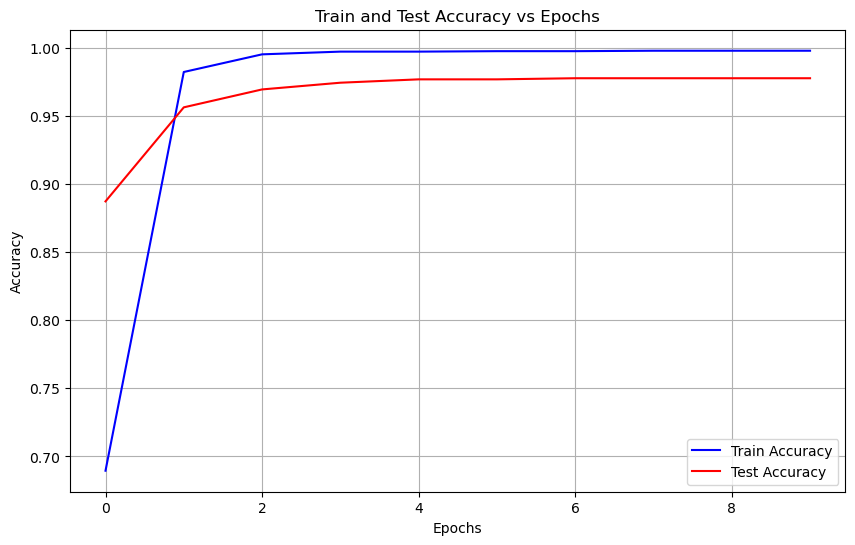

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", color='red')
plt.title("Train and Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Save the graph
plt.savefig("Train_and_Test_Accuracy_vs_Epochs.png", dpi=300, bbox_inches='tight')

# Show the graph
plt.show()

## Precision, Recall, and F1-Score (Classification Metrics):

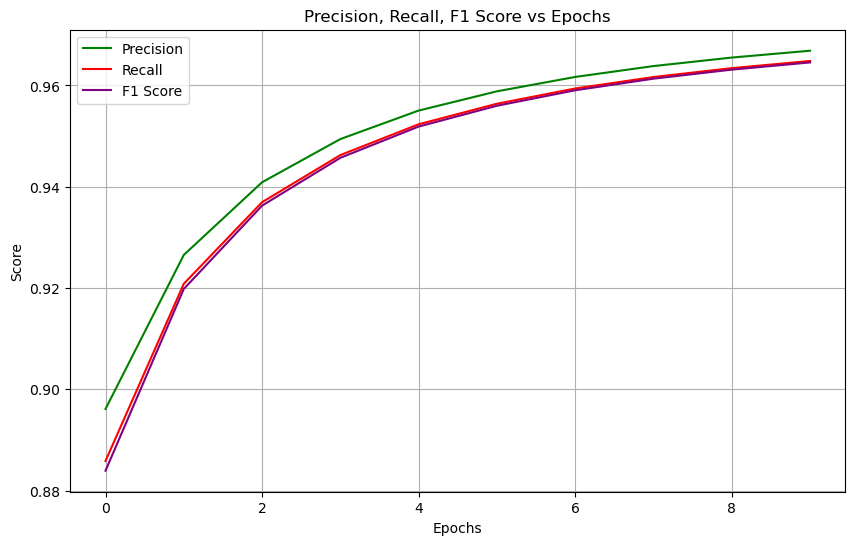

In [34]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, precisions, label="Precision", color='green')
plt.plot(epochs_range, recalls, label="Recall", color='red')
plt.plot(epochs_range, f1_scores, label="F1 Score", color='purple')
plt.title("Precision, Recall, F1 Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Save the graph
plt.savefig("Precision_Recall_F1Score_vs_Epochs.png", dpi=300, bbox_inches='tight')

# Show the graph
plt.show()


## Confusion Matrix:

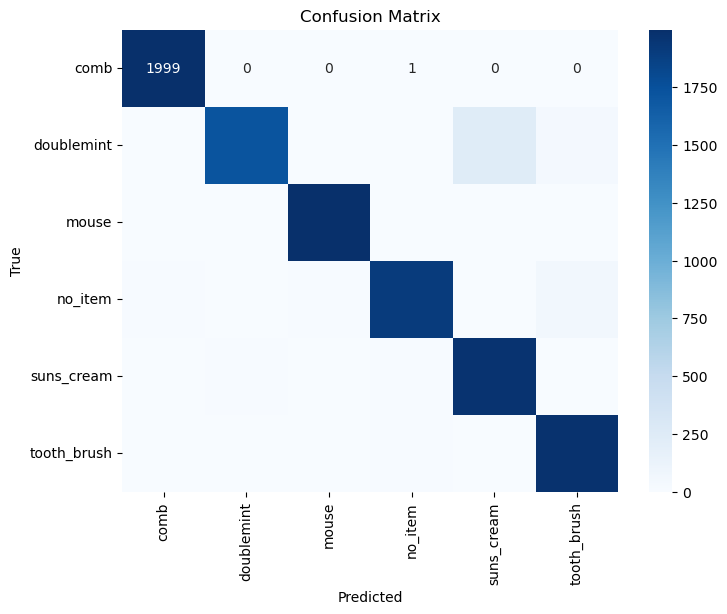

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix after training
cm = confusion_matrix(y_true, y_pred_list)

# Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Save the confusion matrix plot
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Learning Rate vs Loss:

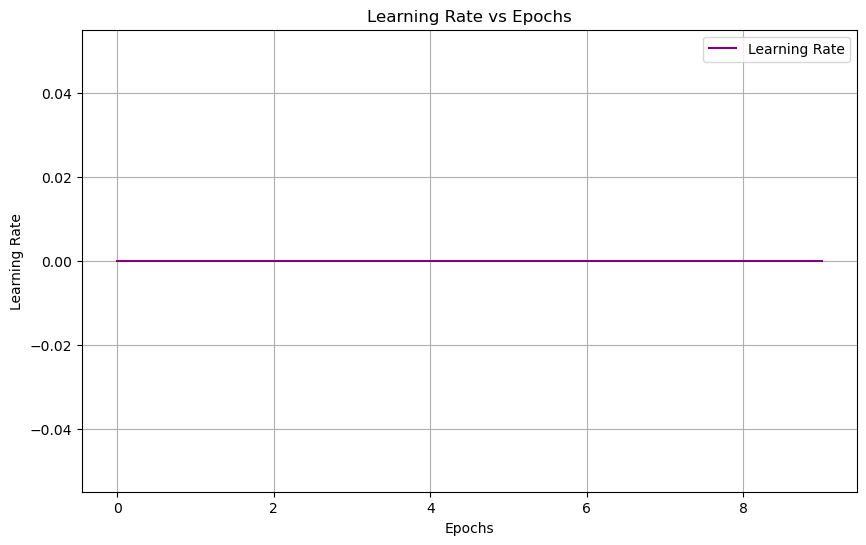

In [36]:
learning_rates = []

for epoch in range(epochs):
    # Before training, record the learning rate
    lr = optimizer.param_groups[0]['lr']
    learning_rates.append(lr)

# Plot and save LR vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), learning_rates, label="Learning Rate", color='purple')
plt.title("Learning Rate vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.savefig("learning_rate_vs_epochs.png", dpi=300, bbox_inches='tight')
plt.show()


## Predicting The Model

In [37]:
from PIL import Image

In [38]:
def predict_image(image_path: str, model: torch.nn.Module, class_names: list, transform, device: torch.device):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the same transform as training
    image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        outputs = model(image_transformed)
        predicted_class_idx = outputs.argmax(dim=1).item()
        predicted_class = class_names[predicted_class_idx]

    return predicted_class

In [41]:
image_path = r"C:\Users\Ishika Saha\Desktop\Aryan\GithubRepo\SDP\Vision Transformer\DATASET\prediction_images\image5.jpg"
prediction = predict_image(image_path, model=pretrained_vit, class_names=class_names, transform=pretrained_vit_transforms, device=device)
print(f"Predicted class: {prediction}")

Predicted class: mouse


## Save only the model weights

In [42]:
torch.save(pretrained_vit.state_dict(), "vit_model_weights.pth")  # You can use .pth or .pt too